In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, pearsonr

from matplotlib.colors import to_hex

set1_hex_colors = [to_hex(c) for c in sns.color_palette("Set1")]

# Define the directory containing the sample directories
base_dir = "/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/cellranger_outs/"
filename = 'cellbender_doublet_detection_filtered_feature_bc_matrix.h5'


## Data downloads

In [2]:
adata_concat = ad.read_h5ad(f'/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')
adata = adata_concat[adata_concat.obs['cell_type'] == 'Epithelial cell'].copy()

# Drop CRPC
#adata = adata[~(adata.obs['type'] == 'CRPC')]
# Add the sample identifier into the obs data
adata.obs.index =  adata.obs['sample'].astype(str) + '_' + adata.obs.index
adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC','CRPC'])
#adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC'])
adata

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 46152 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

In [3]:
# Read in the CNV-based cancer cell annotation and only keep cells with inferred CNVs
concat_obs_data = pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv',index_col=0)
concat_obs_data.index =  concat_obs_data['sample'].astype(str) + '_' + concat_obs_data.index
if 'CNV_status' not in adata.obs.columns.tolist():
    modified_adata_obs = pd.merge(adata.obs,concat_obs_a
    data[['CNV_status']],left_index=True,right_index=True,how='left')
if (modified_adata_obs.index == adata.obs_names).all():
    adata_cnv = adata.copy()
    adata_cnv.obs = modified_adata_obs.copy()
    # Cells with no detected CNAs are classified as benign
    #adata.obs['CNV_status'] = adata.obs['CNV_status'].fillna('Benign')

    # Drop cells with no called copy number
    #adata_cnv = adata[~(adata.obs['CNV_status'].isna())]

adata_cnv

AnnData object with n_obs × n_vars = 46152 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'CNV_status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

## Cancer cell fraction across phenotypes

In [4]:
obs_data = adata_cnv.obs.copy()
obs_data['CNV_status'].value_counts()

# Test whether there's more cancer cells pre- or post-treatment
grp1 = 'PC'
grp2 = 'HSPC'
df = obs_data[obs_data['type'].isin([grp1,grp2])]
crosstab_df = pd.crosstab(df['type'],df['CNV_status']).loc[[grp1,grp2],['CNVpos cancer','Benign']]
print(crosstab_df)
print(fisher_exact(crosstab_df))
print(crosstab_df.sum().sum())

CNV_status  CNVpos cancer  Benign
type                             
PC                   7764    1195
HSPC                10005    7573
SignificanceResult(statistic=4.917773079987203, pvalue=0.0)
26537


/tmp/ipykernel_31210/3911113329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sample'] = df['sample'].cat.remove_unused_categories()
/tmp/ipykernel_31210/3911113329.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df[['CNV_status','sample']].groupby('sample').value_counts(normalize=True)


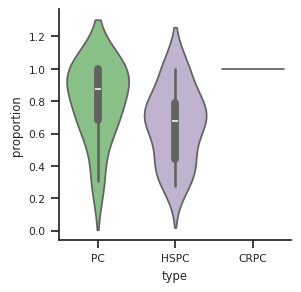

Kruskal-Wallis p = 0.039
Ranksums p = 0.190


In [5]:
df = obs_data[~(obs_data['CNV_status'].isna())]
df['sample'] = df['sample'].cat.remove_unused_categories()
df = df[['CNV_status','sample']].groupby('sample').value_counts(normalize=True)
df = df.reset_index()
df['type'] = [s.split('_')[0] for s in df['sample']]
df['type'] = pd.Categorical(df['type'],categories=['PC','HSPC','CRPC'])
df = df[df['CNV_status'] == 'CNVpos cancer']
df = df[df['proportion'] != 0]


sns.set_theme(style='white',palette='Accent',font_scale=0.7,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(df,x='type',hue='type',y='proportion',ax=ax)
#sns.swarmplot(df,x='type',y='proportion',ax=ax,color='black')

ax.spines[['top','right']].set_visible(False)
plt.show()

from scipy.stats import ranksums,kruskal

stat, p = kruskal(df[df['type'] =='PC']['proportion'],
        df[df['type'] =='HSPC']['proportion'],
        df[df['type'] =='CRPC']['proportion']
)
print(f'Kruskal-Wallis p = {p:.3f}')

stat, p = ranksums(df[df['type'] =='PC']['proportion'],
        df[df['type'] =='HSPC']['proportion']
)
print(f'Ranksums p = {p:.3f}')



## Clustering & gene set scoring

In [5]:
adata_cnv = adata_cnv[adata_cnv.obs['type'] != 'CRPC'].copy()
adata_cnv = adata_cnv[~(adata_cnv.obs['CNV_status'].isna())]

# Set colors
adata_cnv.uns['type_colors'] = set1_hex_colors[:2]

print('Creating neighborhood graph...')
sc.pp.neighbors(adata_cnv, use_rep='X_pca_harmony')

print('Clustering...')
# Leiden clustering
sc.tl.leiden(adata_cnv, resolution=1.0,key_added='leiden_epi')

print('Creating UMAP...')
# UMAP visualization
sc.tl.umap(adata_cnv)


# Drop clusters representing < 1 % of cells
discard_clusters = list(np.where((adata_cnv.obs['leiden_epi'].value_counts(normalize=True) < 0.01))[0])
adata_cnv = adata_cnv[~(adata_cnv.obs['leiden_epi'].isin([str(s) for s in discard_clusters]))].copy()
adata_cnv.obs['leiden_epi'] = adata_cnv.obs['leiden_epi'].cat.remove_unused_categories()

/tmp/ipykernel_53162/576429425.py:5: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_cnv.uns['type_colors'] = set1_hex_colors[:2]


Creating neighborhood graph...
Clustering...


/tmp/ipykernel_53162/576429425.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_cnv, resolution=1.0,key_added='leiden_epi')


Creating UMAP...


In [6]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(prostate_lineage_signatures.columns):
    if 'Lum–' in gset:
        sig = prostate_lineage_signatures['Luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if 'dLum' in gset:
        sig = prostate_lineage_signatures['Duct luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if '_Basal' in gset:
        sig = prostate_lineage_signatures['Basal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    else:
        sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata_cnv,sig,score_name=gset,layer='log1p',use_raw=False)
    prostate_lineage_signatures_dict[gset] = prostate_lineage_signatures[gset].dropna().tolist()

  2%|▏         | 1/42 [00:00<00:34,  1.18it/s]

 12%|█▏        | 5/42 [00:04<00:30,  1.22it/s]

 36%|███▌      | 15/42 [00:12<00:22,  1.22it/s]

 40%|████      | 17/42 [00:14<00:20,  1.22it/s]

 55%|█████▍    | 23/42 [00:18<00:15,  1.22it/s]

 60%|█████▉    | 25/42 [00:20<00:14,  1.21it/s]

 64%|██████▍   | 27/42 [00:22<00:12,  1.20it/s]

 67%|██████▋   | 28/42 [00:23<00:11,  1.19it/s]

 71%|███████▏  | 30/42 [00:24<00:10,  1.19it/s]

 74%|███████▍  | 31/42 [00:25<00:09,  1.18it/s]

 76%|███████▌  | 32/42 [00:26<00:08,  1.19it/s]

       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')


 79%|███████▊  | 33/42 [00:27<00:07,  1.19it/s]

 81%|████████  | 34/42 [00:28<00:06,  1.19it/s]

 86%|████████▌ | 36/42 [00:29<00:05,  1.18it/s]

 88%|████████▊ | 37/42 [00:30<00:04,  1.17it/s]

 90%|█████████ | 38/42 [00:31<00:03,  1.17it/s]

 93%|█████████▎| 39/42 [00:32<00:02,  1.17it/s]

 95%|█████████▌| 40/42 [00:33<00:01,  1.17it/s]

100%|██████████| 42/42 [00:35<00:00,  1.19it/s]


In [55]:
dat = adata_cnv[adata_cnv.obs['type'] == 'HSPC'].copy()
# Overlap removed
sig1 = 'HALLMARK_ANDROGEN_RESPONSE'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'
sig2 = 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'

prostate_lineage_signatures_dict[gset_name] = gset
sc.tl.score_genes(dat,prostate_lineage_signatures_dict[sig1],score_name=sig1,layer='log1p',use_raw=False)
sc.tl.score_genes(dat,prostate_lineage_signatures_dict[sig2],score_name=sig2,layer='log1p',use_raw=False)

#pearsonr(adata_cnv.obs[sig1],adata_cnv.obs[sig2])
pearsonr(dat.obs[sig1],dat.obs[sig2])

PearsonRResult(statistic=0.2582649724130028, pvalue=2.7624513994702724e-261)

/home/ak431480/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ak431480/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


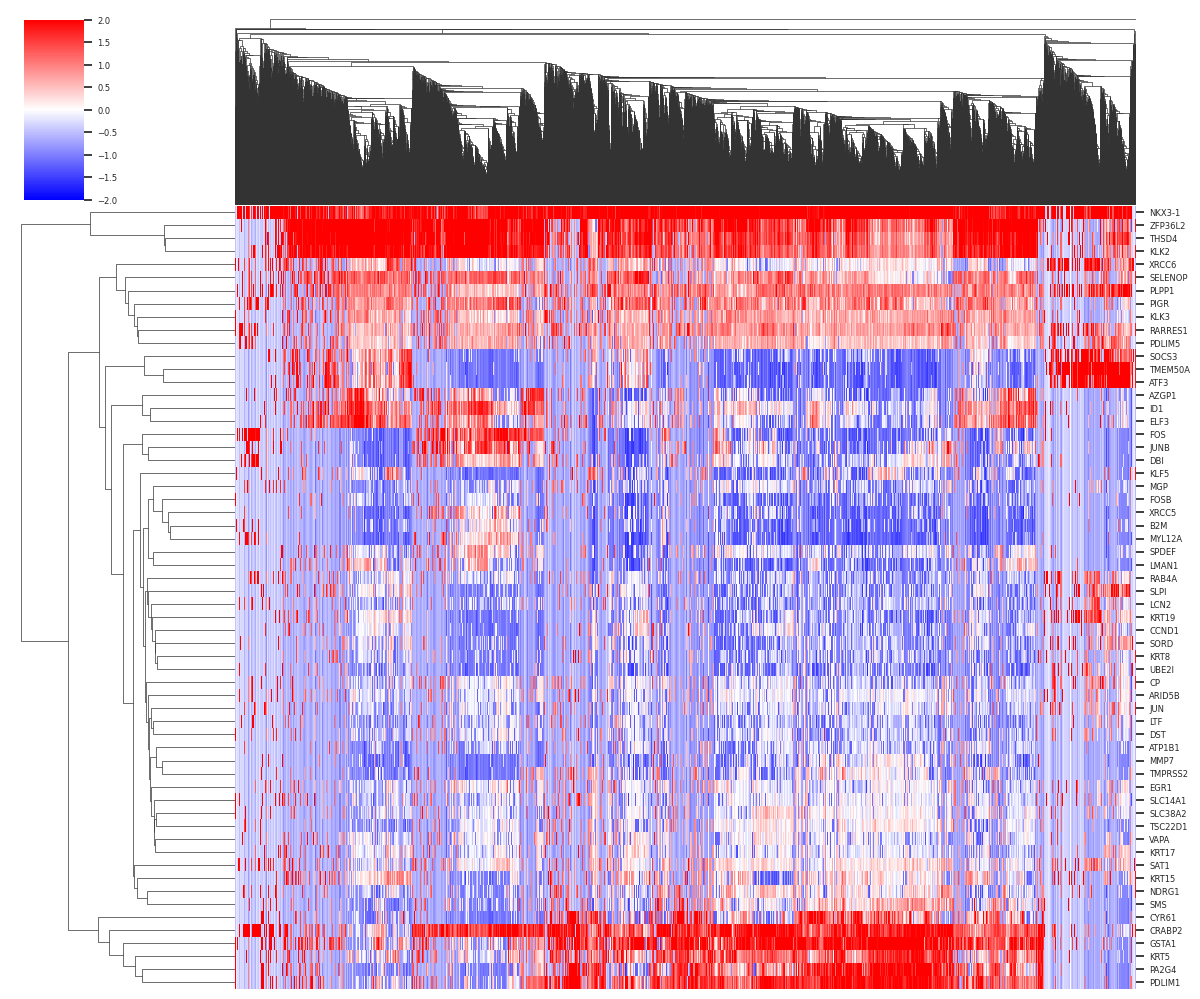

In [120]:

from scipy.stats import zscore

sns.set_theme(style='white',palette='Set1',font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)
dat = adata_cnv[adata_cnv.obs['type'] == 'HSPC'].copy()

# dat is your AnnData subset with a 'log1p' layer
# 1️⃣ Find the top 20 most variable genes (from the log1p layer)
X = np.asarray(dat.layers['log1p'].todense())               # dense or sparse matrix of log1p expression
gene_vars = pd.DataFrame({'var':X.var(axis=0)},index=dat.var_names)

valid_genes = []
for sig in ['HALLMARK_ANDROGEN_RESPONSE','TISS']:#'HALLMARK_TNFA_SIGNALING_VIA_NFKB']:# ,'TISS'
    valid_genes += gene_vars[gene_vars.index.isin(prostate_lineage_signatures_dict[sig])].sort_values('var',ascending=False)[:30].index.tolist()

# Remove duplicates
valid_genes = list(set(valid_genes))

# Filter to those present in dat.var_names
valid_genes_filtered = [g for g in valid_genes if g in dat.var_names]

# Get indices
top_idx = list(np.where(dat.var_names.isin(valid_genes_filtered))[0])


# 2️⃣ Extract expression matrix for those genes
# Convert to pandas DataFrame for seaborn
expr = pd.DataFrame(
    X[:, top_idx].toarray() if hasattr(X, "toarray") else X[:, top_idx],
    index=dat.obs_names,
    columns=valid_genes
).T

expr_z = expr.apply(zscore, axis=0)
expr_z = expr_z.fillna(0)
# 3️⃣ Plot clustermap with viridis palette
p = sns.clustermap(expr_z,cmap='bwr',
                    vmin=-2,#expr_z.unstack().quantile(0.01),
                    vmax=2,#expr_z.unstack().quantile(0.99),
                    xticklabels=False,figsize=(12,10))
p.savefig('/home/ak431480/plots/heatmap.png',dpi=120)
plt.show()


In [126]:
expr.mean(axis=1).sort_values(ascending=False)

NKX3-1     3.336515
ZFP36L2    2.793771
THSD4      2.609327
KLK2       2.488375
CRABP2     2.310615
GSTA1      2.134462
PLPP1      1.863557
PDLIM1     1.855159
SELENOP    1.735768
RARRES1    1.653685
PIGR       1.608307
KRT5       1.565384
PA2G4      1.546402
KLK3       1.442006
PDLIM5     1.368812
ID1        1.303706
XRCC6      1.173632
ELF3       1.163256
CYR61      1.150912
SAT1       1.027126
KRT15      0.907785
AZGP1      0.882696
SMS        0.878158
EGR1       0.812637
SLC38A2    0.793007
NDRG1      0.789744
ARID5B     0.773356
VAPA       0.752889
JUNB       0.736397
KRT17      0.730771
TSC22D1    0.728176
SPDEF      0.700548
SLC14A1    0.690104
DBI        0.686569
CP         0.685146
SOCS3      0.684265
FOS        0.672735
TMEM50A    0.668528
JUN        0.637903
ATF3       0.633944
DST        0.607731
SLPI       0.593700
RAB4A      0.579850
TMPRSS2    0.566595
ATP1B1     0.522166
CCND1      0.514245
LMAN1      0.512878
KRT19      0.510184
LTF        0.510084
MGP        0.499674


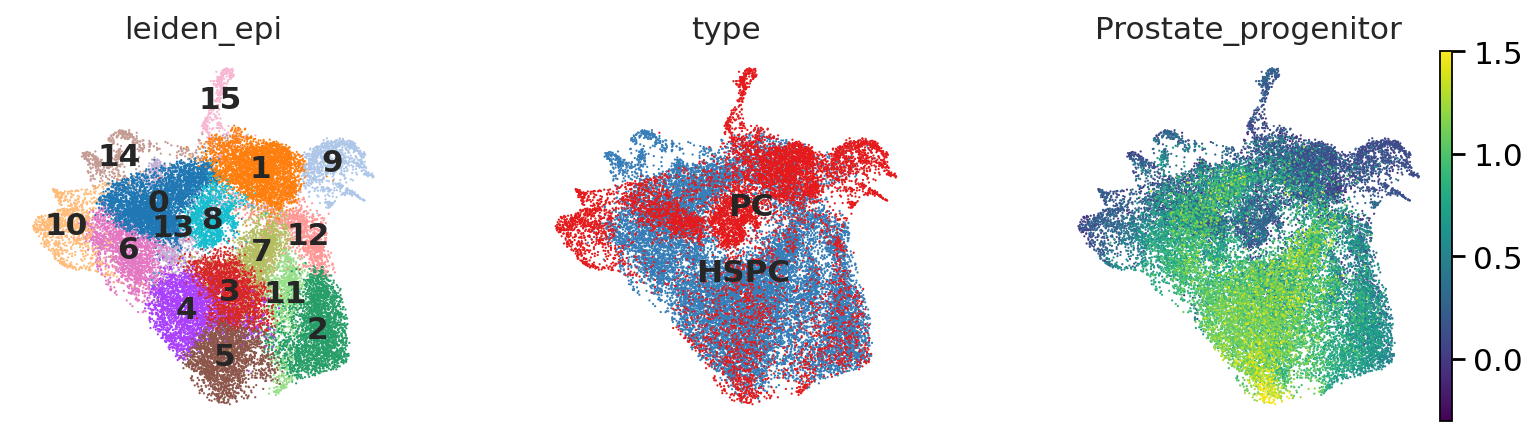

In [22]:
sc.set_figure_params(figsize=(3,3))
#sns.set_theme(style='white',palette='tab10')
sc.pl.umap(adata_cnv,color=['leiden_epi','type','Prostate_progenitor'],size=4,legend_loc='on data',frameon=False,vmax=1.5,cmap='viridis')

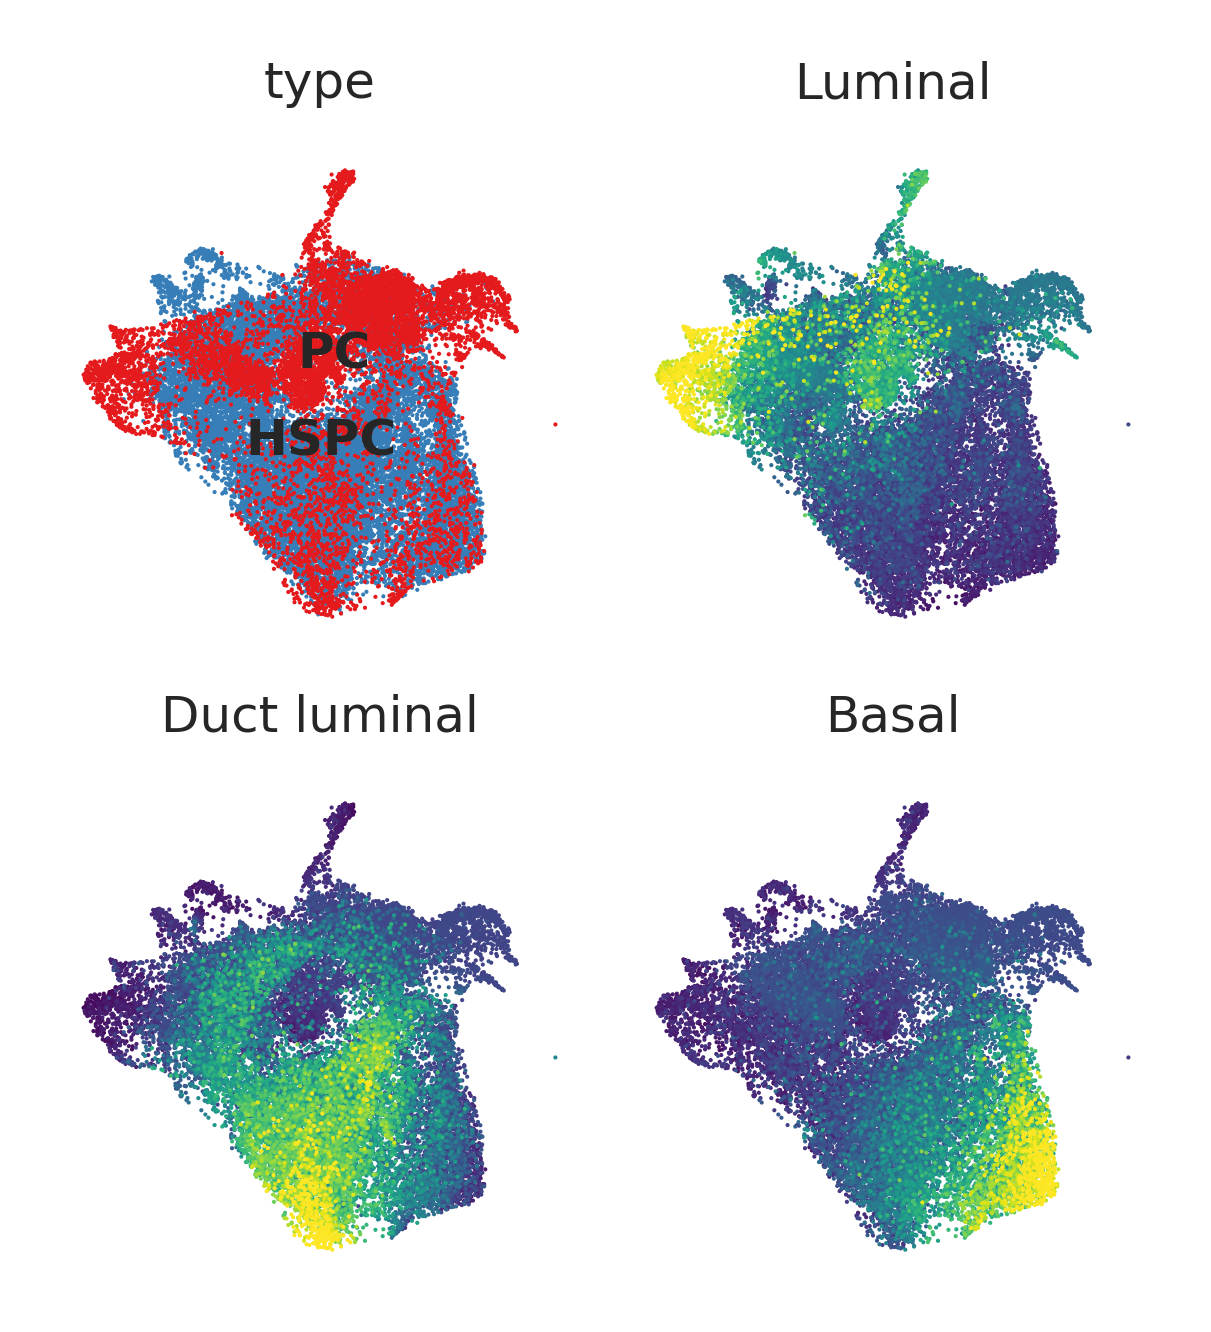

In [28]:
sns.set_theme(style='white',palette='Set1',font_scale=0.6,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Set figure parameters
sc.set_figure_params(figsize=(3, 3.2),fontsize=6)

# Define the variables to plot
variables = ['type', 'Luminal', 'Duct luminal', 'Basal']

# Create subplots in a two-column layout
n_rows = (len(variables) + 1) // 2
fig, axes = plt.subplots(2,2,figsize=(2,2.2),dpi=300)
axes = axes.flatten()

# Generate UMAP plots
for ax, var in zip(axes, variables):
    sc.pl.umap(
        adata_cnv,
        color=var,
        size=1,
        frameon=False,
        cmap='viridis',
        legend_loc='on data',
        vmin='p0',
        vmax='p99',
        show=False,
        colorbar_loc=None,
        ax=ax
    )
    ax.set_title(var)

# Hide unused axes if any
for ax in axes[len(variables):]:
    ax.axis('off')

# Save as modifiable PDF
plt.tight_layout()
plt.savefig('/home/ak431480/plots/lyu_scs_data_lineage_scores_umap.pdf',dpi=600)
plt.show()


In [13]:
adata_cnv.obs[['type','CNV_status']].groupby('type').value_counts()

/tmp/ipykernel_81957/1798893478.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_cnv.obs[['type','CNV_status']].groupby('type').value_counts()


type  CNV_status   
PC    CNVpos cancer    7513
      Benign           1118
HSPC  CNVpos cancer    9755
      Benign           7521
Name: count, dtype: int64

## Sample-specific correlation for ADT-treated tumors

/tmp/ipykernel_53162/3738079927.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby('sample', as_index=False)


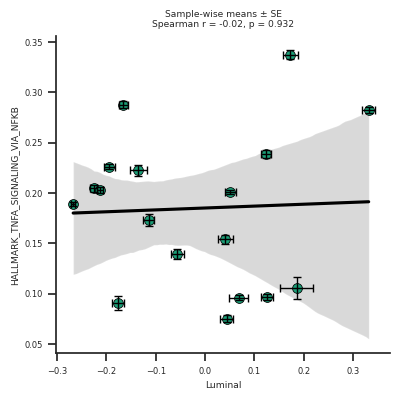

In [29]:
from scipy.stats import spearmanr
sig1 = 'Luminal'
sig2 = 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'#'TISS'#'HALLMARK_TNFA_SIGNALING_VIA_NFKB'

plot_df = adata_cnv.obs.copy()
plot_df = plot_df[plot_df['type'] == 'HSPC']
#plot_df = plot_df[plot_df['type'] == 'PC']
plot_df = plot_df[['sample', sig1, sig2]]

# --- group by sample_id and keep Randomisation ---
grouped = (
    plot_df.groupby('sample', as_index=False)
      .agg(
          mean_1 = (sig1, 'mean'),
          se_1   = (sig1, lambda x: x.std(ddof=1)/np.sqrt(len(x))),
          mean_2 = (sig2, 'mean'),
          se_2   = (sig2, lambda x: x.std(ddof=1)/np.sqrt(len(x))),
      )
)
grouped = grouped.dropna()

# --- correlation on the grouped means ---
rho, pval = spearmanr(grouped['mean_1'], grouped['mean_2'])

sns.set_theme(style='white', palette='Dark2', font_scale=0.55,
              rc={'xtick.bottom': True, 'ytick.left': True})

plt.figure(figsize=(4,4))

# 1️⃣ regression line on sample-wise means
sns.regplot(
    data=grouped,
    x='mean_1',
    y='mean_2',
    scatter=False,   # only the line
    color='black',   # regression line color
   # ci=None          # no confidence band
)

sns.scatterplot(
    data=grouped,
    x='mean_1',
    y='mean_2',
    s=50,
    edgecolor='black'
)

# 3️⃣ add matching-colour error bars
for _, row in grouped.iterrows():
    plt.errorbar(
        row['mean_1'], row['mean_2'],
        xerr=row['se_1'], yerr=row['se_2'],
        fmt='none',
        ecolor='k',
        elinewidth=1,
        capsize=3
    )

plt.xlabel(sig1)
plt.ylabel(sig2)
plt.title(f"Sample-wise means ± SE\nSpearman r = {rho:.2f}, p = {pval:.3f}")
sns.despine()
plt.tight_layout()
plt.show()


In [54]:
obs_data = adata_cnv[adata_cnv.obs['type'] == 'HSPC'].obs
spearmanr(obs_data[sig1],obs_data[sig2])

SignificanceResult(statistic=0.21079676583652, pvalue=9.234048500470643e-173)

## Luminal progenitor gene signature dotplot

{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

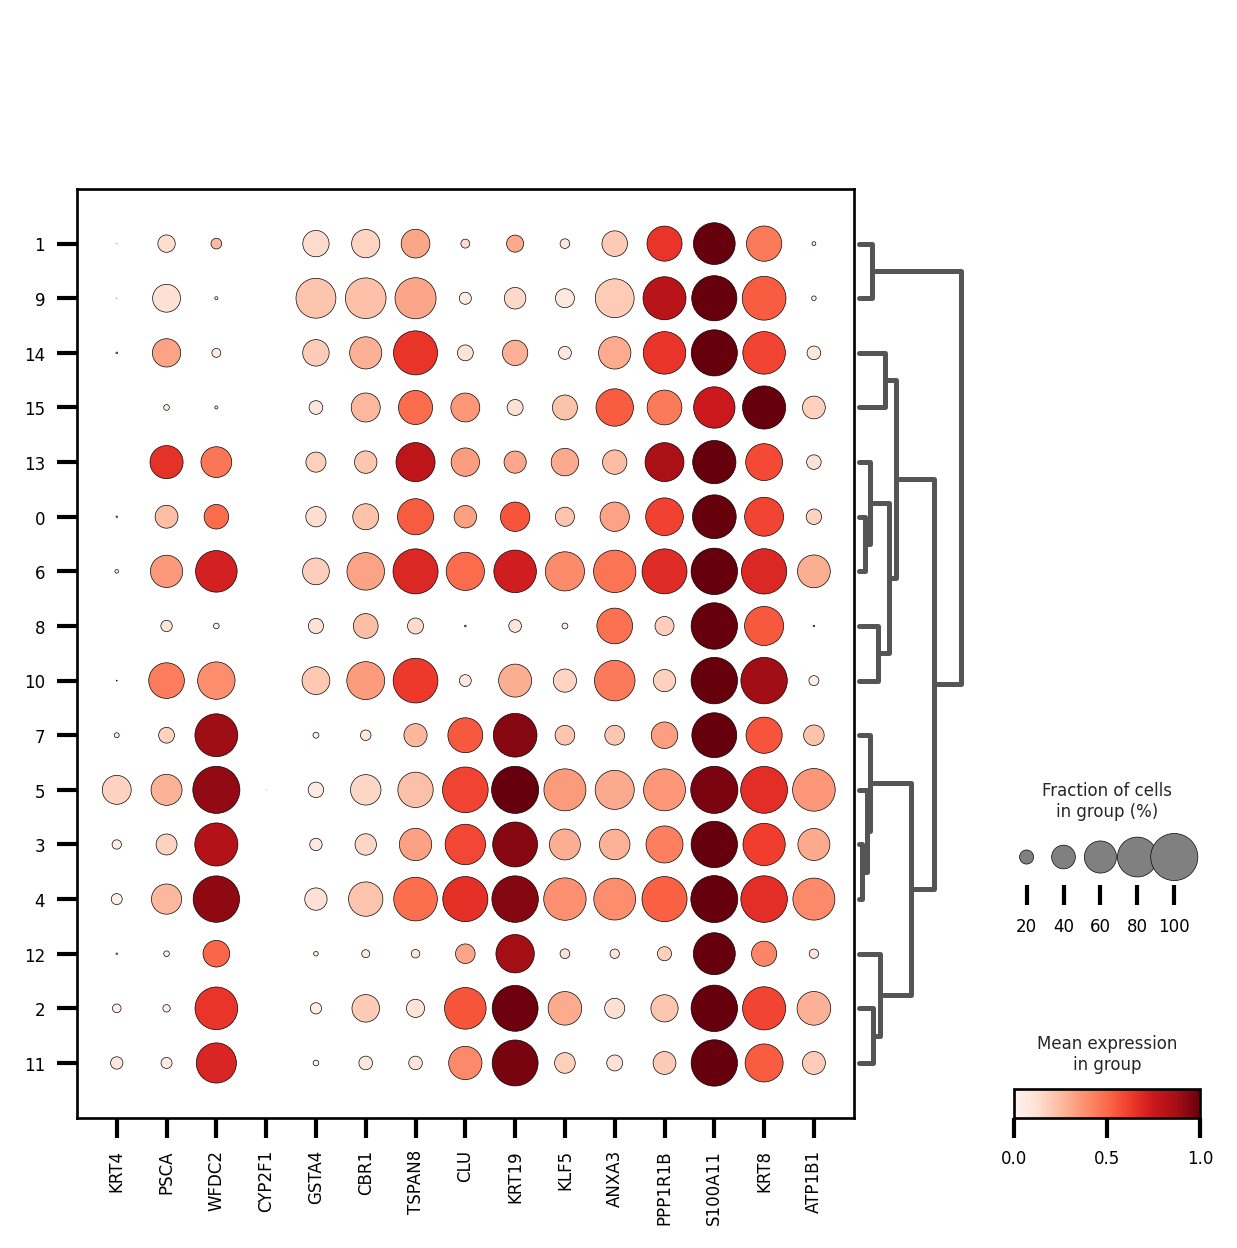

In [50]:
gene_markers = prostate_lineage_signatures_dict['Prostate_progenitor']
sc.set_figure_params(fontsize=6)

sc.tl.dendrogram(adata_cnv,groupby='leiden_epi')
fig, ax = plt.subplots(figsize=(6,6),dpi=120)
sc.pl.dotplot(adata_cnv,groupby='leiden_epi',var_names=gene_markers, standard_scale = 'group',dendrogram=True, use_raw=False, layer='log1p', ax = ax, show=False)

## Differential gene expression analysis of benign & cancer cells

In [14]:
sc.tl.rank_genes_groups(adata_cnv, groupby='type',method='wilcoxon',use_raw=False,layer='log1p',pts=True)
sc.pp.highly_variable_genes(adata_cnv,layer='log1p',n_top_genes=1000)
adata_small = adata_cnv[:,adata_cnv.var['highly_variable']].copy()

deg_df = sc.get.rank_genes_groups_df(adata_small,group='HSPC')
deg_df = deg_df[~(deg_df['names'].str.contains('MT-|RPL|RPS'))] # Drop Mitochondrial & ribosomal
# Add gene signature annotations 
for sig in prostate_lineage_signatures:
    deg_df[sig] = 'FALSE'
    deg_df.loc[(deg_df['names'].isin(prostate_lineage_signatures[sig])),sig] = 'TRUE'


deg_df['DIFF_EXPR'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])
deg_df['OVEREXPRESSED'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])
deg_df['DOWNREG'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])

# Add a clause on 10% of genes of interest expressed in cells
deg_df.loc[((abs(deg_df['logfoldchanges'])>=1) & (deg_df['pvals_adj'] < 0.05)),'DIFF_EXPR'] = 'TRUE'
#deg_df.loc[((deg_df['logfoldchanges'] >= 1) & (deg_df['pvals_adj'] < 0.05) & (deg_df['pct_nz_group'] >= 0.10)),'OVEREXPRESSED'] = 'TRUE'
#deg_df.loc[((deg_df['logfoldchanges'] <= -1) & (deg_df['pvals_adj'] < 0.05)& (deg_df['pct_nz_reference'] >= 0.10)),'DOWNREG'] = 'TRUE'
deg_df.loc[((deg_df['logfoldchanges'] >= 1) & (deg_df['pvals_adj'] < 0.05)),'OVEREXPRESSED'] = 'TRUE'
deg_df.loc[((deg_df['logfoldchanges'] <= -1) & (deg_df['pvals_adj'] < 0.05)),'DOWNREG'] = 'TRUE'

In [39]:
deg_df[deg_df.columns[:7]].reset_index(drop=True).to_excel('/home/ak431480/supp_tables/CNA_pos_cancer_cells_ADT_exposed_vs_naive.xlsx')

### Volcanoplot

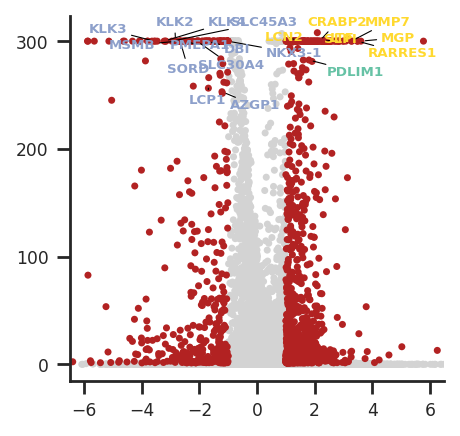

In [ ]:
sns.set_theme(style='white', palette=sns.color_palette(['lightgray', 'firebrick']),font_scale=0.7,rc={
    'xtick.bottom': True,
    'ytick.left': True})

plot_df = deg_df.copy()
sig = 'Proximal_luminal'

ctype_colors_dict = {
 'Luminal': '#8da0cb',
 'Basal': '#66c2a5',
 'Ductal luminal': '#ffd92f',
 }


# Generate a different epsilon for each row
epsilons = 10 ** np.random.uniform(-310, -290, size=plot_df.shape[0])
#plot_df['-log10padj'] = -np.log10(plot_df['pvals_adj'] + epsilons)
plot_df['pvals_adj'] = plot_df['pvals_adj'].replace(0,1e-300)
plot_df['-log10padj'] = -np.log10(plot_df['pvals_adj'])
plot_df = plot_df.sort_values('DIFF_EXPR')

signatures = ['Basal','Ductal luminal','Luminal']#,'CRPC-AR','CRPC-SCL','CRPC-WNT','CRPC-NE','JAK_STAT_FGFR']
#signatures = ['BPECT Basal Identity', 'BPECT Club Identity','BPECT Hillock Identity','BPECT Luminal Identity',]

valid_genes = prostate_lineage_signatures[signatures].unstack().dropna().tolist()

fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(
    data=plot_df,
    x='logfoldchanges',
    y='-log10padj',
    s = 10,
    hue='DIFF_EXPR',
    linewidth=0,
    edgecolor='black',
    legend=None,
    ax=ax,
)

# Annotate top genes
top_genes = plot_df[(plot_df['names'].isin(valid_genes) & (plot_df['DIFF_EXPR'] == 'TRUE'))].sort_values('-log10padj',ascending=False)[:20]
from adjustText import adjust_text

# Collect text objects
texts = []
for _, row in top_genes.iterrows():
    c = ctype_colors_dict[row[signatures].idxmax()]
    ha = 'right' if row['logfoldchanges'] <= -1 else 'left'
    x = row['logfoldchanges']
    y = row['-log10padj']
    text = ax.text(x, y, row['names'], fontsize=6, ha=ha, va='center', color=c, weight='bold')
    texts.append(text)


ax.set_yticks([0,100,200,300])
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('')
plt.ylabel('')
plt.xlim(-6.5, 6.5)

# Adjust text to avoid overlap and add leader lines
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5),expand_axes=False,min_arrow_len=1.0)
plt.savefig('/home/ak431480/plots/scs_cna_pos_hspc_vs_pca_degs_volcanoplot.pdf')
plt.show()


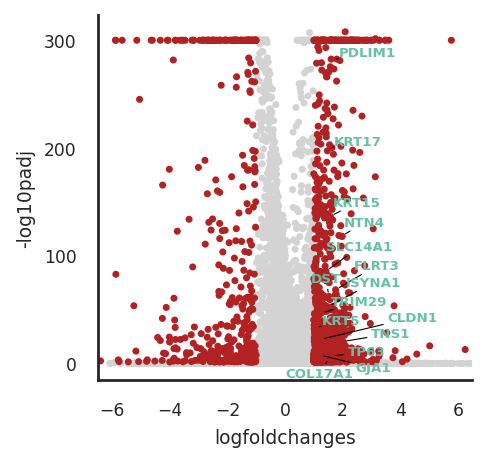

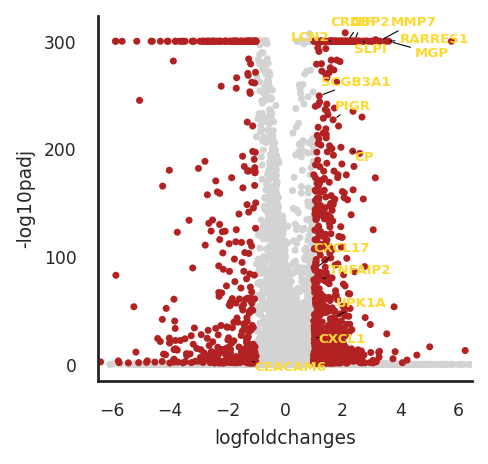

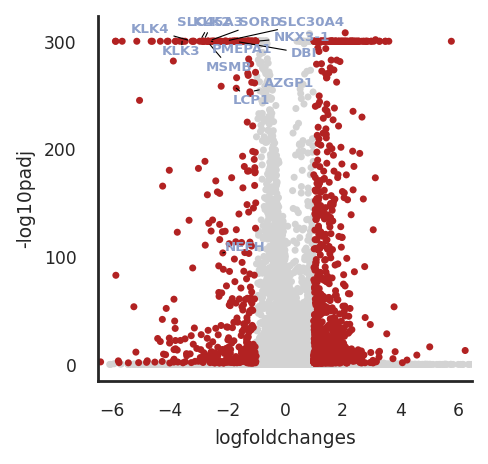

In [ ]:
sns.set_theme(style='white', palette=sns.color_palette(['lightgray', 'firebrick']),font_scale=0.7)

plot_df = deg_df.copy()
sig = 'Luminal'

ctype_colors_dict = {
 'Luminal': '#8da0cb',
 'Basal': '#66c2a5',
 'Ductal luminal': '#ffd92f',
 }

# Cap at 1e-300
plot_df['pvals_adj'] = plot_df['pvals_adj'].replace(0,1e-300)
plot_df['-log10padj'] = -np.log10(plot_df['pvals_adj'])
plot_df = plot_df.sort_values('DIFF_EXPR')

signatures = ['Basal','Ductal luminal','Luminal']#,'CRPC-AR','CRPC-SCL','CRPC-WNT','CRPC-NE','JAK_STAT_FGFR']
for sig in signatures:
    valid_genes = prostate_lineage_signatures[[sig]].unstack().dropna().tolist()

    fig, ax = plt.subplots(figsize=(3,3))
    sns.scatterplot(
        data=plot_df,
        x='logfoldchanges',
        y='-log10padj',
        s = 10,
        hue='DIFF_EXPR',
        linewidth=0,
        edgecolor='black',
        legend=None,
        ax=ax,
    )

    # Annotate top genes
    top_genes = plot_df[(plot_df['names'].isin(valid_genes) & (plot_df['DIFF_EXPR'] == 'TRUE'))].sort_values('-log10padj',ascending=False)[:20]
    from adjustText import adjust_text

    # Collect text objects
    texts = []
    for _, row in top_genes.iterrows():
        c = ctype_colors_dict[row[[sig]].idxmax()]
        x = row['logfoldchanges']
        y = row['-log10padj']
        text = ax.text(x, y, row['names'], fontsize=6, color=c, weight='bold',)
        texts.append(text)


    ax.set_yticks([0,100,200,300])
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlim(-6.5, 6.5)

    # Adjust text to avoid overlap and add leader lines
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5),expand_axes=False,min_arrow_len=1.0)
    #plt.tight_layout()
    plt.savefig(f'/home/ak431480/plots/scs_cna_pos_hspc_vs_pca_degs_volcanoplot_{sig}.pdf')
    plt.show()


## CNA-positive cancer cells only

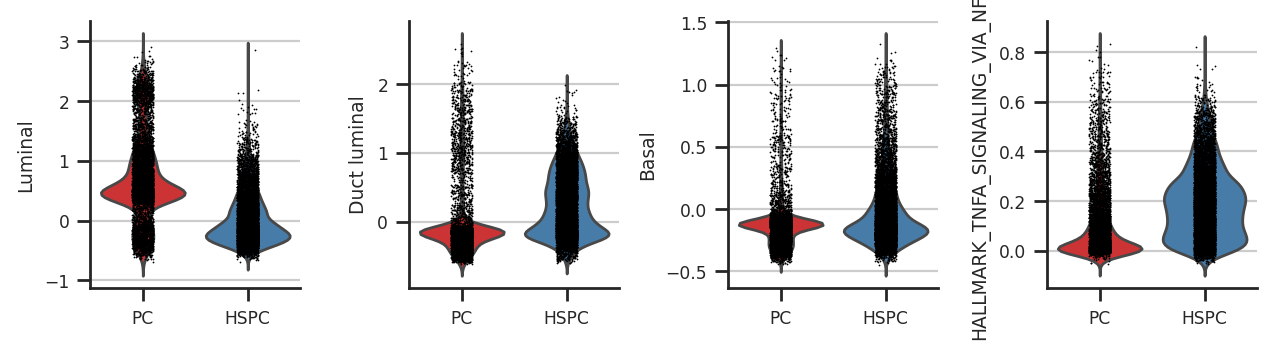

In [ ]:
sns.set_theme(style='white',palette=sns.color_palette('Set1'),font_scale=0.7,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)
obs_data = adata_cnv.obs.copy()
obs_data = obs_data[obs_data['CNV_status'] == 'CNVpos cancer']

obs_data['type'] = obs_data['type'].cat.reorder_categories(['PC','HSPC'])

signatures = ['Luminal','Duct luminal','Basal','HALLMARK_TNFA_SIGNALING_VIA_NFKB']

fig, axs = plt.subplots(1,len(signatures),figsize=(len(signatures)*2,2.2))

for idx, sig in enumerate(signatures):
    ax = axs[idx]
    sns.stripplot(
        obs_data,
        x = 'type',
        y = sig,
        s=0.8,
        color='black',
        ax = ax,
    )
    sns.violinplot(
        obs_data,
        x = 'type',
        y = sig,
        inner=None,
        hue='type',
        ax = ax,
    )

    ax.spines[['top','right']].set_visible(False)
    #ax.set_yticks([0,1,2])
    ax.grid(axis='y')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig(f'/home/ak431480/plots/prostate_lineage_scores_violins.pdf')
plt.show()


In [21]:
# Save to a file
obs_data.to_csv('/home/ak431480/lyu_2024_cancer_cells_score_data.csv')

### Differential gene expression analysis

In [ ]:
adata_cnv_cancer = adata_cnv[adata_cnv.obs['CNV_status'] == 'CNVpos cancer'].copy()

sc.tl.rank_genes_groups(adata_cnv_cancer, groupby='type',method='wilcoxon',use_raw=False,layer='log1p',pts=True)
sc.pp.highly_variable_genes(adata_cnv_cancer,layer='log1p',n_top_genes=1000)
adata_small = adata_cnv_cancer[:,adata_cnv_cancer.var['highly_variable']].copy()

deg_df = sc.get.rank_genes_groups_df(adata_small,group='HSPC')
deg_df = deg_df[~(deg_df['names'].str.contains('MT-|RPL|RPS'))] # Drop Mitochondrial & ribosomal
# Add gene signature annotations 
for sig in prostate_lineage_signatures:
    deg_df[sig] = 'FALSE'
    deg_df.loc[(deg_df['names'].isin(prostate_lineage_signatures[sig])),sig] = 'TRUE'


deg_df['DIFF_EXPR'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])
deg_df['OVEREXPRESSED'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])
deg_df['DOWNREG'] = pd.Categorical(np.repeat('FALSE',len(deg_df)),categories=['FALSE','TRUE'])

# Add a clause on 10% of genes of interest expressed in cells
deg_df.loc[((abs(deg_df['logfoldchanges'])>=1) & (deg_df['pvals_adj'] < 0.05)),'DIFF_EXPR'] = 'TRUE'
#deg_df.loc[((deg_df['logfoldchanges'] >= 1) & (deg_df['pvals_adj'] < 0.05) & (deg_df['pct_nz_group'] >= 0.10)),'OVEREXPRESSED'] = 'TRUE'
#deg_df.loc[((deg_df['logfoldchanges'] <= -1) & (deg_df['pvals_adj'] < 0.05)& (deg_df['pct_nz_reference'] >= 0.10)),'DOWNREG'] = 'TRUE'
deg_df.loc[((deg_df['logfoldchanges'] >= 1) & (deg_df['pvals_adj'] < 0.05)),'OVEREXPRESSED'] = 'TRUE'
deg_df.loc[((deg_df['logfoldchanges'] <= -1) & (deg_df['pvals_adj'] < 0.05)),'DOWNREG'] = 'TRUE'

### Plot the average log2Fold change

In [ ]:
from itertools import chain
epithelial_subset_signatures = prostate_lineage_signatures.columns[3:20].tolist()
valid_genes = set(list(chain.from_iterable([prostate_lineage_signatures_dict[k] for k in epithelial_subset_signatures])))
deg_df_subset = deg_df[deg_df['names'].isin(valid_genes)]
deg_df_subset = deg_df_subset[['names','logfoldchanges','pvals_adj','pct_nz_group','DIFF_EXPR'] + epithelial_subset_signatures]
deg_df_subset = deg_df_subset[deg_df_subset['pvals_adj'] < 0.05]
deg_df_subset = deg_df_subset[np.abs(deg_df_subset['logfoldchanges']) >= 1]
deg_df_subset = deg_df_subset.reset_index(drop=True)

df_lst = []
for sig in epithelial_subset_signatures:
    df = deg_df_subset[deg_df_subset[sig] == 'TRUE'][['names','logfoldchanges','pvals_adj','pct_nz_group','DIFF_EXPR']].copy()
    if sig.startswith('Lum−') or sig == 'Luminal':
        annot = 'Luminal'
    elif 'dLum' in sig or sig == 'Ductal luminal':
        annot = 'Ductal luminal'
    elif '_Basal' in sig or sig == 'Basal':
        annot = 'Basal'
    
    df['geneset'] = sig
    df['celltype'] = annot
    df_lst.append(df)
plot_df = pd.concat(df_lst,axis=0).reset_index(drop=True)

# Filter according to the number of genes passing the differentially expressed filter
valid_genesets = []
val_counts = plot_df[plot_df['logfoldchanges'] >= 1]['geneset'].value_counts()
valid_genesets += val_counts[val_counts >= 5].index.tolist()
val_counts = plot_df[plot_df['logfoldchanges'] <= -1]['geneset'].value_counts()
valid_genesets += val_counts[val_counts >= 5].index.tolist()

plot_df = plot_df[plot_df['geneset'].isin(valid_genesets)]

# Order the genesets by logfoldchanges sum
geneset_order = plot_df[['geneset','logfoldchanges']].groupby('geneset').sum().sort_values('logfoldchanges',ascending=False).index.tolist() 
#geneset_order = plot_df[plot_df['DIFF_EXPR'] == 'TRUE'][['geneset','pct_nz_group']].groupby('geneset').mean().sort_values('pct_nz_group',ascending=False).index.tolist()

plot_df['geneset'] = pd.Categorical(plot_df['geneset'],categories=geneset_order)
plot_df = plot_df.sort_values('geneset')

In [26]:

# Get the first 20 epithelial subset signatures
epithelial_subset_signatures = prostate_lineage_signatures.columns[3:20].tolist()

# Initialize results DataFrame
res_df = pd.DataFrame(index=epithelial_subset_signatures, columns=['color', '-log10pval', 'n_overlap'])

# Perform Fisher's exact test for each signature
for sig in epithelial_subset_signatures:
    # Upregulated contingency table and test
    contig_table_up = pd.crosstab(deg_df['OVEREXPRESSED'], deg_df[sig]).loc[['TRUE', 'FALSE'], ['TRUE', 'FALSE']]
    oddsr_up, pval_up = fisher_exact(contig_table_up)

    # Downregulated contingency table and test
    contig_table_dn = pd.crosstab(deg_df['DOWNREG'], deg_df[sig]).loc[['TRUE', 'FALSE'], ['TRUE', 'FALSE']]
    oddsr_dn, pval_dn = fisher_exact(contig_table_dn)

    # Choose the more significant result
    if pval_up < pval_dn:
        res_df.loc[sig, '-log10pval'] = -np.log10(pval_up)
        res_df.loc[sig, 'n_overlap'] = contig_table_up.loc['TRUE','TRUE']
    else:
        res_df.loc[sig, '-log10pval'] = np.log10(pval_dn)
        res_df.loc[sig, 'n_overlap'] = contig_table_dn.loc['TRUE','TRUE']

# Assign colors based on signature names
for gset in res_df.index:
    if gset.startswith('Lum−') or gset == 'Luminal':
        res_df.loc[gset, 'color'] = 'Luminal'
    elif 'dLum' in gset or gset == 'Ductal luminal':
        res_df.loc[gset, 'color'] = 'Ductal luminal'
    elif '_Basal' in gset or gset == 'Basal':
        res_df.loc[gset, 'color'] = 'Basal'

# Create a mapping dict
enrichment_pval_mapping_dict = res_df[['-log10pval']].to_dict()['-log10pval']

# p < 0.05
res_df = res_df[abs(res_df['-log10pval']) > -np.log10(0.05)]

# Only those with >=5 DEGs
res_df = res_df[res_df['n_overlap'] >= 5]

# Sort results by significance
res_df = res_df.sort_values('-log10pval', ascending=False)
res_df

,color,-log10pval,n_overlap
B1_Basal-ESR1,Basal,17.327842,13
d3_dLum-LTF,Ductal luminal,9.883103,9
Lum−LTF,Luminal,7.069598,7
d1_dLum-Club,Ductal luminal,6.890671,7
B2_Basal,Basal,5.527667,6
d5_dLum,Ductal luminal,4.378292,5
B3_Basal-GPRC5A,Basal,4.261119,5
Lum−SFTPA2,Luminal,-4.313049,5
Lum−type2,Luminal,-5.894865,6
d4_dLum-NKX3-1,Ductal luminal,-8.429333,8


/tmp/ipykernel_476526/644619050.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=-30)


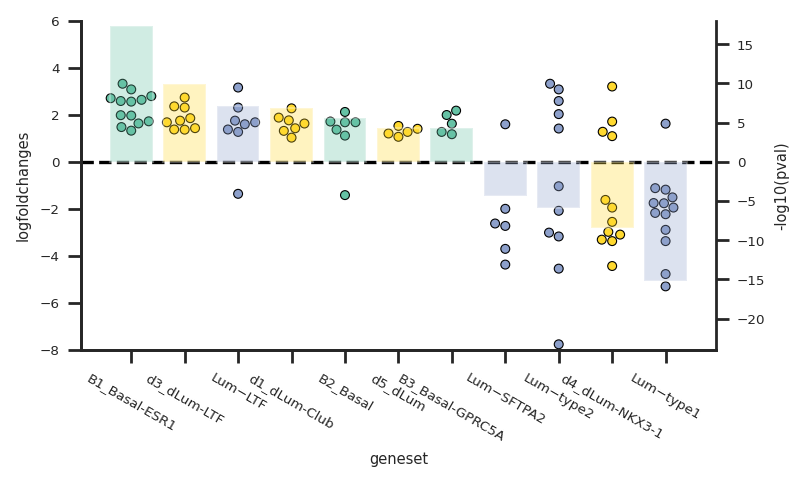

In [27]:
#geneset_order = [gset for gset in geneset_order if gset in res_df.index.tolist()]
geneset_order = res_df.index.tolist()

ctype_colors_dict = {
    'Luminal': '#8da0cb',
    'Basal': '#66c2a5',
    'Ductal luminal': '#ffd92f',
}

sns.set_theme(style='white', palette=sns.color_palette(['#66c2a5', '#ffd92f','#8da0cb']), font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

fig, ax1 = plt.subplots(figsize=(5, 3))

# Swarmplot on left y-axis
sns.swarmplot(
    data=plot_df,
    x='geneset',
    y='logfoldchanges',
    hue='celltype',
    dodge=False,
    size=4,
    linewidth=0.5,
    edgecolor='black',
    ax=ax1,
    legend = False,
    order=geneset_order
)

ax1.set_ylabel('logfoldchanges')
ax1.axhline(y=0, linestyle='--', color='k')
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=-30)
ax1.set_ylim(-8.0,6)

# Barplot on right y-axis
ax2 = ax1.twinx()
bar_colors = [ctype_colors_dict[res_df.loc[g, 'color']] for g in geneset_order]
ax2.bar(geneset_order, res_df.loc[geneset_order, '-log10pval'], color=bar_colors, alpha=0.3, width=0.8)
ax2.set_ylabel('-log10(pval)')
ax2.set_ylim(-24,18)

ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)

plt.tight_layout()

plt.savefig('/home/ak431480/plots/combined_barplot_swarmplot_deg_resutlts.pdf')
plt.show()


In [44]:
genesets = ['Ductal luminal','Basal','B1_Basal-ESR1','d1_dLum-Club']
genes = []
for g in genesets: genes += prostate_lineage_signatures_dict[g]
tiss_signature_df = deg_df[((deg_df['names'].isin(genes)) & (deg_df['OVEREXPRESSED'] == 'TRUE'))][['names','scores', 'logfoldchanges', 'pvals_adj'] + genesets].reset_index(drop=True)

# Save the table to excel
tiss_signature_df.to_excel(f'./supp_tables/tiss_signature_{len(tiss_signature_df)}_genes.xlsx')

In [36]:
deg_df

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,Basal,Ductal luminal,Luminal,...,CRPC-AR,CRPC-WNT,CRPC-NE,CRPC-SCL,JAK_STAT_FGFR,IL1B MDSCs,PMN-MDSCs,DIFF_EXPR,OVEREXPRESSED,DOWNREG
4,FAU,82.921227,1.733579,0.0,0.0,0.983803,0.986424,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
19,PTMA,72.261139,1.747144,0.0,0.0,0.980113,0.953547,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
27,RACK1,69.053398,1.323741,0.0,0.0,0.981138,0.984826,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
28,EIF1,69.028389,1.559325,0.0,0.0,0.965864,0.953148,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
37,H3F3B,66.233856,1.613105,0.0,0.0,0.963506,0.947158,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26256,ALOX15B,-68.871529,-5.783578,0.0,0.0,0.008303,0.621589,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
26257,MESP1,-71.966705,-3.015720,0.0,0.0,0.123014,0.785172,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
26258,SORD,-73.957741,-2.986966,0.0,0.0,0.215582,0.849328,FALSE,FALSE,TRUE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
26259,KLK4,-74.087852,-3.307727,0.0,0.0,0.252178,0.822441,FALSE,FALSE,TRUE,...,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE


## Gene set scores and celltype identity

In [336]:
signatures = ['Basal','Ductal luminal','Luminal']
obs_data = adata_cnv.obs.copy()
#obs_data = obs_data[['CNV_status','type'] + signatures]
obs_data = obs_data[obs_data['CNV_status'] == 'CNVpos cancer']

# Get score max values and types
obs_data['celltype'] = obs_data[signatures].idxmax(axis=1)
obs_data['max_value'] = obs_data[signatures].max(axis=1)
# Don't account for cells with <= 0 max score

q_thershold = np.quantile(obs_data['max_value'],0.5)
#q_thershold = 0

#df = obs_data.copy()
df = obs_data[obs_data['max_value'] > q_thershold]

# Fraction 
print((df[df['type'] == 'PC']['celltype'].value_counts()/ (df['type'] == 'PC').sum() *100).round(1))
print((df[df['type'] == 'HSPC']['celltype'].value_counts()/ (df['type'] == 'HSPC').sum().round(2) *100).round(1))

celltype
Luminal           79.7
Ductal luminal    16.8
Basal              3.5
Name: count, dtype: float64
celltype
Ductal luminal    62.1
Luminal           27.2
Basal             10.7
Name: count, dtype: float64


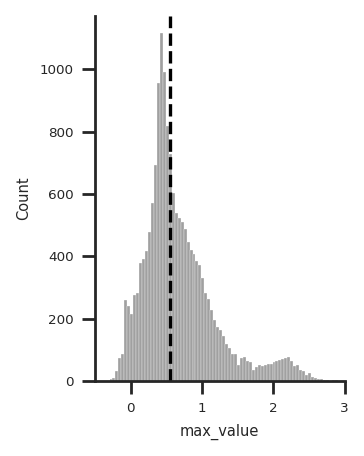

In [337]:
sns.set_theme(style='white', palette=sns.color_palette(['lightgray', 'firebrick']),font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})
fig, ax = plt.subplots(figsize=(2,3))
sns.histplot(obs_data['max_value'],ax=ax,color='gray')


ax.axvline(x=q_thershold,color='k',linestyle='--')
ax.set_xlim(-0.5,3)

ax.spines[['top','right']].set_visible(False)
plt.savefig('/home/ak431480/plots/epithelial_lineage_max_signature_score_histogram.pdf')
plt.show()



### Scatterplot of Ductal luminal – basal score

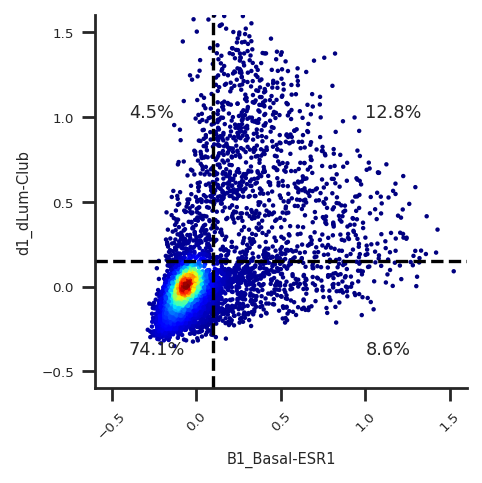

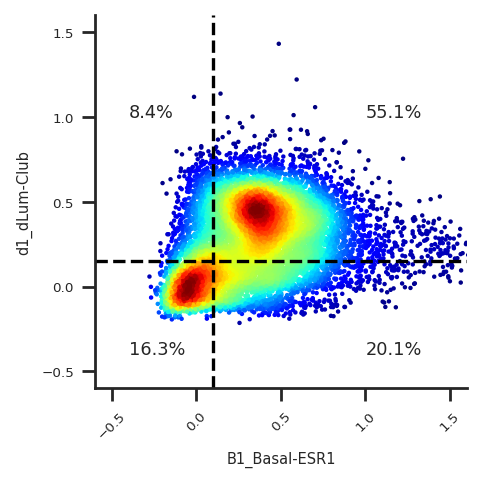

In [403]:
from scipy.stats import gaussian_kde,zscore
sns.set_theme(style='white', palette=sns.color_palette(['#66c2a5', '#ffd92f','#8da0cb']),font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True})

sig1 = 'B1_Basal-ESR1'
sig2 = 'd1_dLum-Club'
#sig2 = 'd3_dLum-LTF'


for t in ['PC','HSPC']:
    #df = adata.obs.copy()
    df = adata_cnv_cancer.obs.copy()
    #df = df[df['max_value'] > q_thershold].copy()
    df = df[df['type'] == t].copy()

    #q_thershold_x = np.quantile(df[sig1],0.5)
    #q_thershold_y = np.quantile(df[sig2],0.5)
    q_thershold_x = 0.10
    q_thershold_y = 0.15


    fig, ax = plt.subplots(figsize = (3,3))

    # Calculate the point density
    xy = np.vstack([df[sig1], df[sig2]])
    kernel = gaussian_kde(xy)(xy)

    sns.scatterplot(
        data=df,
        x=sig1,
        y=sig2,
        c=kernel,
        linewidth=0,
        cmap="jet",
        vmin = np.quantile(kernel,0),
        vmax = np.quantile(kernel,0.99),
        s=4,
        ax=ax,
    )

    ax.axvline(x=q_thershold_x,linestyle='--',color='k')
    ax.axhline(y=q_thershold_y,linestyle='--',color='k')

    pct_shares = [(len(df[((df[sig1] <= q_thershold_x) & (df[sig2] <= q_thershold_y))]) / len(df))*100,
    (len(df[((df[sig1] <= q_thershold_x) & (df[sig2] > q_thershold_y))]) / len(df))*100,
    (len(df[((df[sig1] > q_thershold_x) & (df[sig2] > q_thershold_y))]) / len(df))*100,
    (len(df[((df[sig1] > q_thershold_x) & (df[sig2] <= q_thershold_y))]) / len(df))*100]

    text_coords = [(-0.4,-0.4),(-0.4,1.0),(1.0,1.0),(1.0,-0.4)]
    
    for i, val in enumerate(pct_shares):
        ax.text(s=f'{pct_shares[i]:.1f}%',x = text_coords[i][0], y = text_coords[i][1],size = 8)

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim(-0.6,1.6)
    ax.set_ylim(-0.6,1.6)
    
    ax.set_xticks([-0.5,0,0.5,1,1.5])
    ax.set_yticks([-0.5,0,0.5,1,1.5])

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'/home/ak431480/plots/score_scatter_FACS_like_{t}.pdf')

    plt.show()

## Analysis of CNV-positive cancer cells

### Find the differentially expressed TFs

/home/ak431480/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ak431480/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


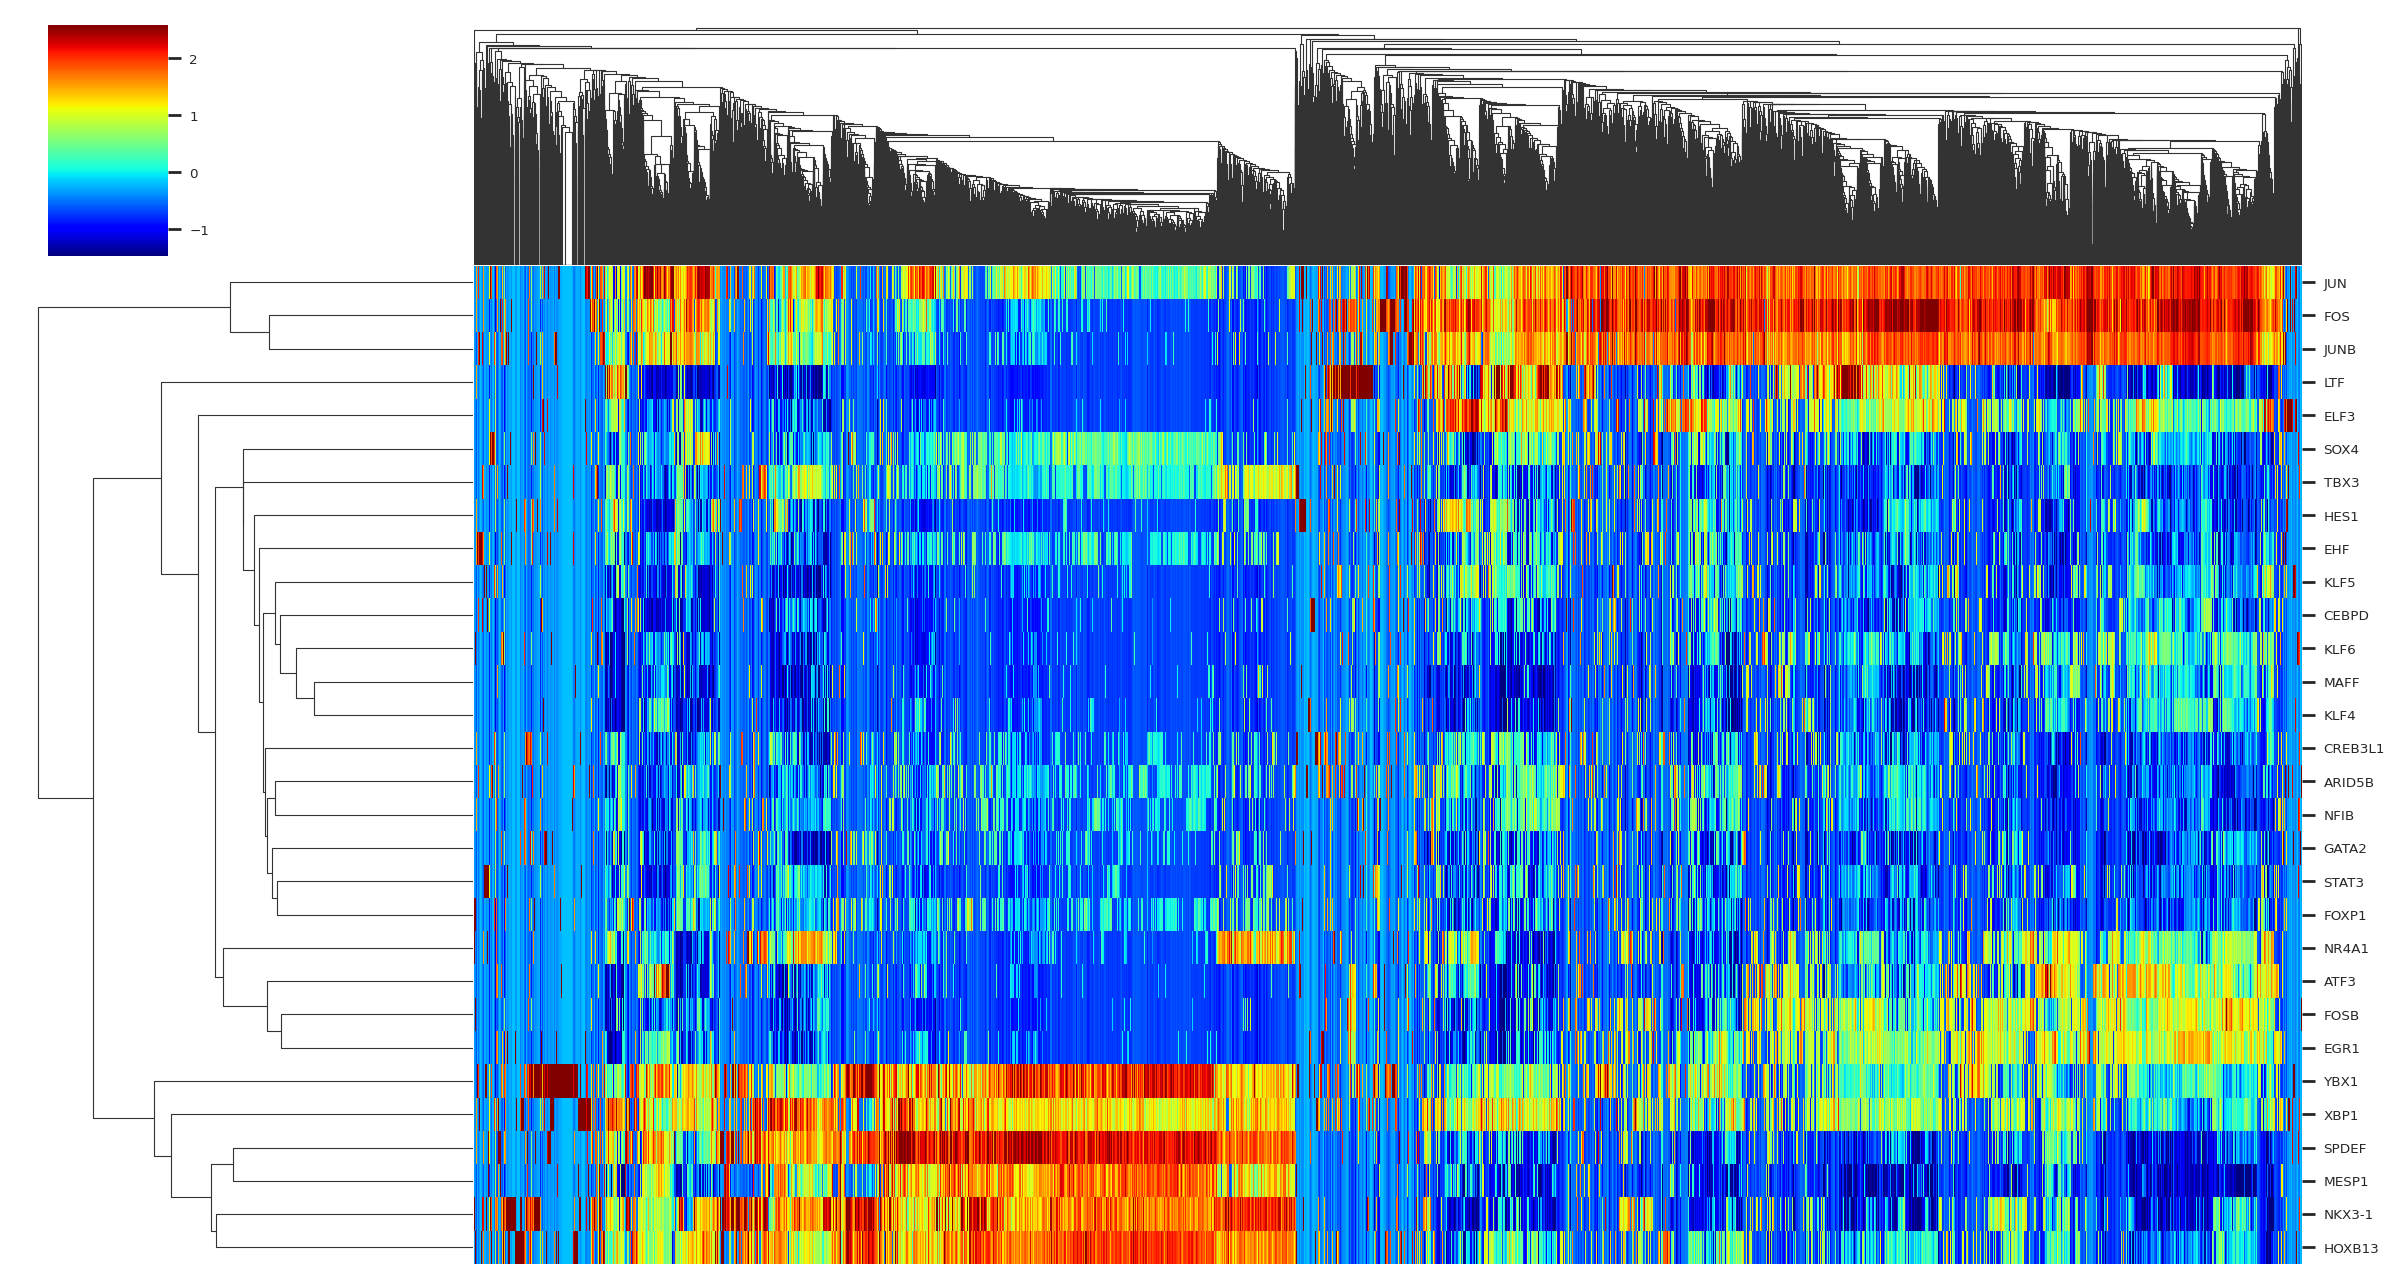

In [391]:
from scipy.stats import zscore

# Download df annotation and filter
known_tfs = pd.read_excel('/home/ak431480/known_tfs_Lambert_2018.xlsx')
known_tfs = known_tfs[((known_tfs['Is TF?'] == 'Yes') & (known_tfs['TF assessment'] == 'Known motif'))]

#Format the data
adata_tfs = adata_cnv_cancer[:,adata_cnv_cancer.var.index.intersection(known_tfs['Name'])].copy()
X_tfs = np.array(adata_tfs.layers['log1p'].todense())
tfs_expr_df = pd.DataFrame(X_tfs,columns=adata_tfs.var.index,index=adata_tfs.obs_names).T

# Only keep the top 10 TFs with most variation
valid_tfs = tfs_expr_df.var(axis=1).sort_values(ascending=False)[:30].index.tolist()
plot_data = tfs_expr_df.loc[valid_tfs]

# Calculate z-scores and drop NaN cells
plot_data = zscore(plot_data,axis=0)
plot_data = plot_data[plot_data.columns[np.where(~plot_data.isna().any(axis=0))[0]]]

p = sns.clustermap(plot_data,cmap='jet',vmin=plot_data.unstack().quantile(0.01),vmax=plot_data.unstack().quantile(0.99),xticklabels=False,figsize=(15,8))


/home/ak431480/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


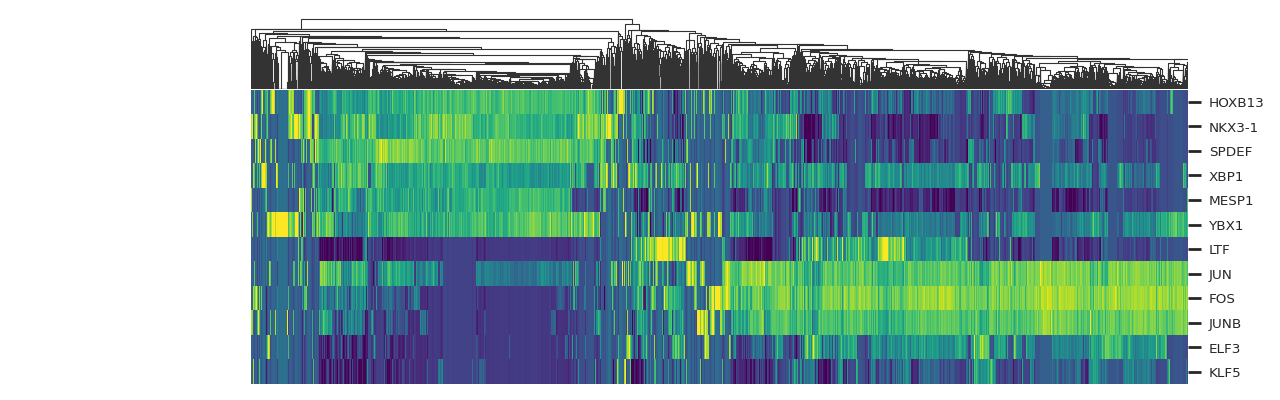

In [404]:
p.ax_heatmap.yaxis.get_majorticklabels()
custom_tfs = ['HOXB13','NKX3-1','SPDEF','XBP1','MESP1','YBX1','LTF','JUN','FOS','JUNB','ELF3','KLF5']

#Format the data
adata_tfs = adata_cnv_cancer[:,custom_tfs].copy()
X_tfs = np.array(adata_tfs.layers['log1p'].todense())
plot_data = pd.DataFrame(X_tfs,columns=adata_tfs.var.index,index=adata_tfs.obs_names).T

# Calculate z-scores and drop NaN cells
plot_data = zscore(plot_data,axis=0)
plot_data = plot_data[plot_data.columns[np.where(~plot_data.isna().any(axis=0))[0]]]

p = sns.clustermap(plot_data,cmap='viridis',vmin=plot_data.unstack().quantile(0.01),vmax=plot_data.unstack().quantile(0.99),xticklabels=False,figsize=(8,2.5),row_cluster=False,cbar_pos=None)
p.savefig('/home/ak431480/plots/tf_heatmap.png',dpi=300)
gene_names = [text.get_text() for text in p.ax_heatmap.get_yticklabels()]


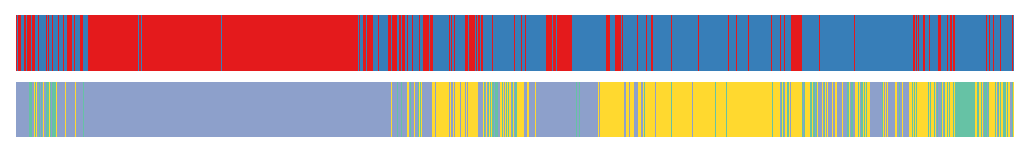

In [408]:
## Create annotation
obs_annot = adata_cnv_cancer.obs.copy()
obs_order = p.data2d.columns
annot_df = obs_annot.loc[obs_order]
annot_df['type_binary'] = (annot_df['type']=='HSPC').astype(int)

annot_df['celltype'] = annot_df[signatures].idxmax(axis=1)
annot_df['celltype_encoded'] = annot_df['celltype'].map({'Luminal':0,'Ductal luminal':1,'Basal':2})

fig,axs = plt.subplots(2,1,figsize=(8,1))

ctype_colors_dict = {
 'Luminal': '#8da0cb',
 'Ductal luminal': '#ffd92f',
 'Basal': '#66c2a5',
 }

pal = sns.color_palette([sns.color_palette('Set1')[0],sns.color_palette('Set1')[1]])

sns.heatmap(
    annot_df[['type_binary']].T,
    cmap=pal,
    ax=axs[0],
    xticklabels=False,
    yticklabels=False,
    cbar=False
    )
 
pal = sns.color_palette(ctype_colors_dict.values())
sns.heatmap(
    annot_df[['celltype_encoded']].T,
    cmap=pal,
    ax=axs[1],
    xticklabels=False,
    yticklabels=False,
    cbar=False
    )

plt.savefig('/home/ak431480/plots/colorbar_for_tf_heatmap.pdf')
plt.savefig('/home/ak431480/plots/colorbar_for_tf_heatmap.png',dpi=300)